# 06wk-1, 07wk-1: UCF101 영상자료 분류

최규빈  
2024-10-17

<a href="https://colab.research.google.com/github/guebin/MP2024/blob/main/posts/06wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-zBs464epBRfxPpNBAKqBMS&si=It99ZTYMQHJkCk6z>

# 2. ref

ref:
<https://huggingface.co/docs/transformers/tasks/video_classification>

`-` 실행이 되지 않음

![](https://github.com/guebin/MP2024/blob/main/posts/fig1.png?raw=true)

`-` 해결방법:

1.  위의 그림에서
    `/usr/local/lib/python3.10/dist-packages/pytorchvideo/transforms/augmentations.py`
    를 클릭
2.  아래의 그림과 같이 코드를 수정

![](https://github.com/guebin/MP2024/blob/main/posts/fig2.png?raw=true)

# 3. 예비학습

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import imageio
import IPython.display

## A. 이미지 자료의 이해

`-` `plt.imshow(...)` 에서 `...` 자리에 오는 numpy array의 shape이
(??,??) 와 같이 2차원 꼴이면 흑백이미지를 출력

In [10]:
np.array([[0, 150], [0,255]])

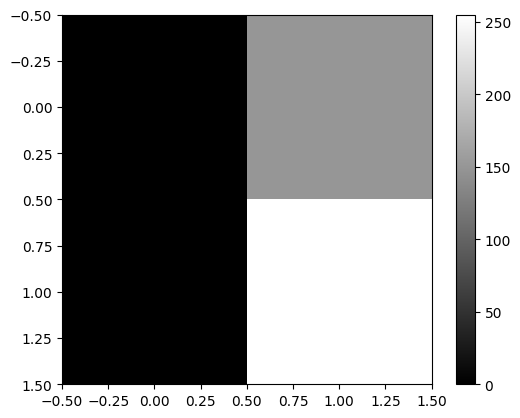

In [11]:
plt.imshow(np.array([[0, 150], [0,255]]),cmap='gray')
plt.colorbar()

`-` `plt.imshow(...)` 에서 `...` 자리에 오는 numpy array의 shape이
(??,??,3) 이러한 형태이면 칼라이미지를 출력

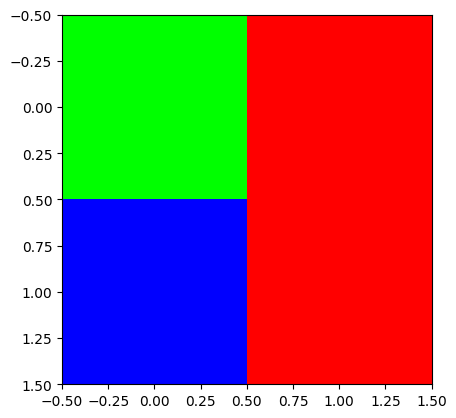

In [12]:
R = np.array([[0,255],
              [0,255]])
G = np.array([[255,0],
              [0,  0]])
B = np.array([[0,  0],
              [255,0]])
plt.imshow(np.stack([R,G,B],axis=-1))

`-` `plt.imshow(...)`에서 `...` 자리에 오는 numpy array 의 dtype이
int인지 float인지에 따라서 시각화 결과가 다름

-   int일 경우: 0을 최소값, 255를 최대값으로 생각하고 그림을 그려줌.
-   float일 경우: 0.0을 최소값, 1.0을 최대값으로 생각하고 그림을 그려줌.

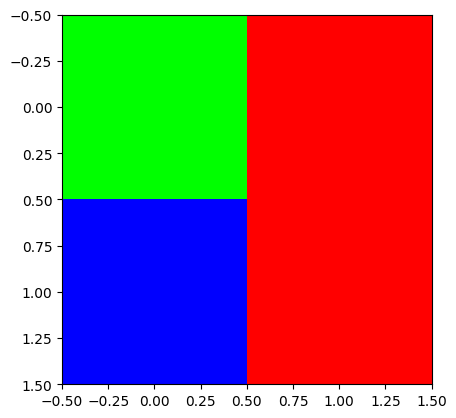

In [13]:
R = np.array([[0,1],
              [0,1]])
G = np.array([[1,0],
              [0,0]])
B = np.array([[0,0],
              [1,0]])
#plt.imshow(np.stack([R,G,B],axis=-1))
plt.imshow(np.stack([R,G,B],axis=-1).astype(float))

## B. `tsr.permute()`

`-` 실수로 R,G,B 를 이상한 방식으로 stack 했다고 가정하자.

In [14]:
R = np.array([[0,255],[0,255]])
G = np.array([[255,0],[0,0]])
B = np.array([[0,0],[255,0]])
# img = np.stack([R,G,B],axis=-1) # <-- 원래는 이걸 하려고 했었음..
img = np.stack([R,G,B]) # <-- 실수로 이렇게 만들었다고 하자...
img.shape

`-` 차원이 맞지 않아서 `plt.imshow(img)`이 동작하지 않음. 동작하기
위해서는 `plt.imshow(...)` 에서 `...` 자리에 있는 numpy array가 HWC 와
같은 형식으로 되어야함. (그런데 지금은 CHW 임)

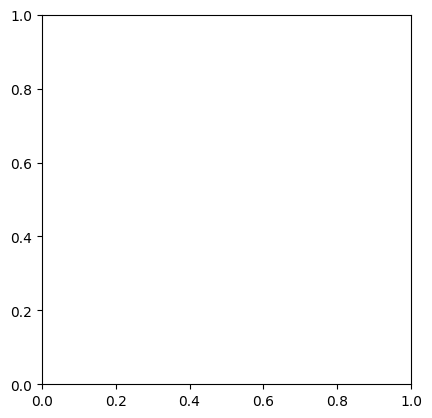

In [15]:
plt.imshow(img)

`-` 에러를 피하기 위해서는 차원을 `(3,2,2)` 에서 `(2,2,3)` 으로
바꾸어야함.

In [22]:
img.reshape(2,2,3)

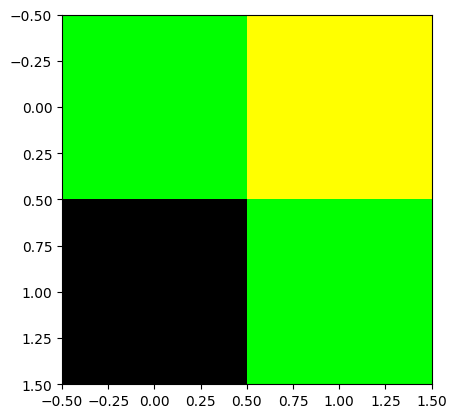

In [23]:
plt.imshow(img.reshape(2,2,3)) # ?? 이상한 그림이 나왔음

-   우리가 원하는 그림은 아니네??
-   왜 이런일이 생기는가??

`-` 이미지자료의 차원을 바꾸고 싶다면 `reshape`을 쓰지 말고
`np.transpose`를 이용하라

In [24]:
img.reshape(2,2,3),  np.transpose(img,(1,2,0))

-   위의 두개의 array는 차원이 같음. $\to$ 그림자체는 둘다 그려짐
-   그렇지만 같은 array는 아님 $\to$ 당연히 그림도 달라짐

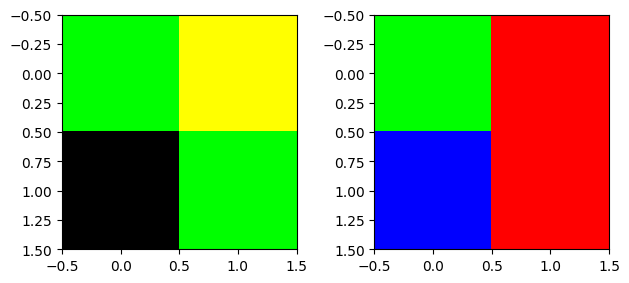

In [25]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(img.reshape(2,2,3))
ax[1].imshow(np.transpose(img, (1,2,0)))
fig.tight_layout()

-   왼쪽은 이상한 그림, 오른쪽은 우리가 원하는 그림

`-` numpy array 가 아니고 pytorch tensor 일 경우에는 아래의 방법으로
변환

In [26]:
arr = np.random.rand(2,4,3)
tsr = torch.tensor(arr)

In [27]:
np.transpose(arr,(2,0,1)) # (2,4,3) --> (3,2,4)

In [28]:
tsr.permute(2,0,1) # (2,4,3) --> (3,2,4)
# np.transpose(tsr,(2,0,1)) # 같은코드

## C. 동영상 자료 이해

`-` 동영상자료 = 여러사진들의 모음 = \[사진1, 사진2, 사진3, 사진4, ….\]

In [ ]:
np.random.seed(43052)
v = (np.random.rand(4,60,60,3)*255).astype("uint8")
v[0,:,:,0] = 255 # 첫번쨰 프레임의 R 채널을 모두 최대치로 설정
v[1,:,:,1] = 255 # 두번쨰 프레임의 G 채널을 모두 최대치로 설정
v[2,:,:,2] = 255 # 세번째 프레임의 B 채널을 모두 최대치로 설정

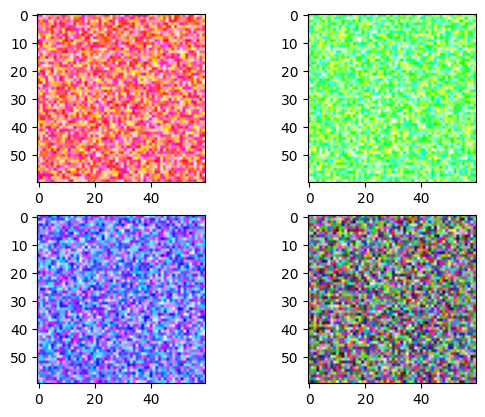

In [ ]:
fig, ax = plt.subplots(2,2)
# ax[0][0].imshow(v[0,:,:,:])
# ax[0][1].imshow(v[1,:,:,:])
# ax[1][0].imshow(v[2,:,:,:])
# ax[1][1].imshow(v[3,:,:,:])
ax[0][0].imshow(v[0])
ax[0][1].imshow(v[1])
ax[1][0].imshow(v[2])
ax[1][1].imshow(v[3])

In [ ]:
frames = [frame for frame in v]
#frames = [사진1, 사진2, 사진3, 사진4]

In [ ]:
imageio.mimsave("sample.gif",frames)

In [1]:
#IPython.display.Image("sample.gif")

## D. `np.clip()`

In [ ]:
arr = np.array([[300, -20, 150], [400, 100, 0], [255, 500, -100]])
arr

In [ ]:
np.clip(arr,0,255)

# 4. 살펴보기

## A. 다운로드

`-` imports

In [1]:
import huggingface_hub

`-` 처음에는 `/root/.cache` 에 `huggingface`라는 폴더가 존재하지 않음

In [6]:
file_path = huggingface_hub.hf_hub_download(
    repo_id="sayakpaul/ucf101-subset",
    filename="UCF101_subset.tar.gz",
    repo_type="dataset"
)

In [7]:
file_path

`-` 위의명령어를 실행하면 `/root/.cache` 에 적당한 폴더가 만들어지고
`UCF101_subset.tar.gz` 와 같은 파일이 다운로드 되어있음

`-` `huggingface_hub.hf_hub_download` 함수의 역할: (1)
`UCF101_subset.tar.gz` 파일을 다운로드 (2) 다운로드한 압축파일의 경로를
`str`으로 리턴

## B. 압축풀기

`-` imports

In [4]:
import tarfile

`-` 아래의 코드는 현재폴더에 `UCF101_subset.tar.gz` 파일의 압축을
해제하는 코드이다.

In [12]:
# file_path는 다운로드한 압축파일이 존재하는 경로와 파일명이 string으로 저장되어있음.
with tarfile.open(file_path) as t:
     t.extractall(".") # 여기에서 "."은 현재폴더라는 의미

`-` `tarfile.TarFile`의 인스턴스 `t` 가 가지는 주요기능

In [33]:
t = tarfile.open(file_path)
t.extractall("./asdf")

`-` `tarfile.TarFile`의 인스턴스 `t`가 가지는 덜 중요한 기능: 더 이상
압축을 풀고 싶지 않을때, `t.close()`를 이용하여 `t.extractall()`을
봉인할 수 있다.

In [43]:
t = tarfile.open(file_path) # t 오브젝트 생성
t.closed # 오브젝트 생성 직후에는 t.closed 는 False

In [35]:
t.extractall("./여기에")

In [36]:
t.extractall("./저기에")

In [37]:
t.close() # 더이상 무분별하게 압축을 풀고싶지 않다면 이걸 실행

In [42]:
t.closed # 그렇다면 t.closed 가 True로 되고

In [41]:
t.extractall("./또풀어") # 에러발생

`-` `tarfile.TarFile`의 인스턴스 `t`가 가지는 덜 중요한 기능2:
`t._check()` 은 t.closed = True일때 실행하면 에러를 발생시키는 역할을
한다.

In [47]:
print(t.closed)
t._check() # t.closed 가 open 일 경우에는 에러X

False

In [48]:
t.close()
print(t.closed)
t._check() # t.closed 가 open 일 경우에는 에러X

True

`-` with의 이해

*아래와 같은 코드를 작성하고 싶음*

``` python
1. `t`를 만듦. 즉 `TarFile`의 인스턴스를 만듦.
2. `t`가 열린상태인지 체크 (=압축풀기가 가능한 상태인지 체크를 해줌, 닫힌상태라면 에러메시지 발생하고 진행중지)
3. 압축해제
4. `t`를 닫힌상태로 만듦.
```

*아래와 같이 쓸 수 있음*

In [53]:
t = tarfile.open(file_path)
t._check()
t.extractall(".")
t.close()

*위의 코드는 아래의 코드와 같은 효과*

In [55]:
with tarfile.open(file_path) as t:
  ## 시작코드 -- t._ckech() 이 자동실행 (사실은 t.__enter__()이 실행)
  t.extractall(".") ## 본코드
  ## 마무리코드 -- t.close() 이 자동실행 (사실은 t.__exit__()이 실행)

In [58]:
t.closed # 예쁘게 잘 닫혀있음..

> **Note**
>
> `with ... as ???:`에서 `???` 자리에 들어가는 오브젝트는
> `__enter__()`와 `__exit__()`라는 숨겨진 메서드를 가진 오브젝트여야
> 한다.
>
> ``` python
> import tarfile
>
> # tar 파일을 열고 자동으로 닫아주는 with 문 사용
> with tarfile.open('example.tar.gz') as tar:  # tarfile 객체는 __enter__, __exit__ 메서드를 가짐
>     tar.extractall(path='output_folder')  # 본래 코드: tar 파일 안의 파일들을 추출
> # 여기서 `tar.__exit__()`가 호출되어 tar 파일이 자동으로 닫힘
> ```
>
> 위의 예시에서 `tarfile.open()`이 반환하는 `tar` 오브젝트가
> `__enter__()`와 `__exit__()` 를 가지고 있다. 위의 코드가 실행되는
> 원리는 대략적으로 아래와 같다.
>
> 1.  **with 문이 실행되면**, 먼저 `tar.__enter__()`가 호출된다. 이
>     메서드는 tar 파일을 열고, 파일을 처리할 준비를 한다.
>
>     ``` python
>     tarfile.open('example.tar.gz')  # 이 때 tar.__enter__() 호출
>     ```
>
> 2.  **본래 코드 실행**: 이후 with 문 안의 본래 코드, 즉
>     `tar.extractall(path='output_folder')`가 실행되어 tar 파일의
>     내용을 추출한다.
>
>     ``` python
>     tar.extractall(path='output_folder')  # 본래 코드 실행
>     ```
>
> 3.  **with 문이 종료될 때**, `tar.__exit__()` 메서드가 호출되어 tar
>     파일이 자동으로 닫힌다. 이로 인해 파일을 명시적으로 닫을 필요가
>     없어지며, 자원 관리가 안전하게 이루어진다.
>
>     ``` python
>     # with 문 종료 시 tar.__exit__() 호출
>     ```
>
> 이렇게 with 문은 `__enter__()`와 `__exit__()` 메서드를 가진 객체를
> 활용하여, 자원의 열림과 닫힘을 자동으로 처리하는 구조이다.

## C. 동영상확인

`-` 코덱문제로 인하여 `v_Basketball_g01_c01.avi`는 재생이 안됨

`-` 아래의 명령어를 사용하여 `v_Basketball_g01_c01.avi` 파일을
`output_video.mp4` 로 변환

``` bash
!ffmpeg -i UCF101_subset/train/Basketball/v_Basketball_g01_c01.avi -vcodec libx264 -acodec aac output_video.mp4 -y
```

`-` `output_video.mp4` 를 다운로드하고 재생

## D. 동영상 불러오기

`-` imports

In [20]:
import pytorchvideo.data
# import os
# import pathlib

### `#`. 동영상(avi) $\to$ 텐서

In [21]:
_train_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("random", 10),
    decode_audio = False,
#    transform = train_transform,
)

In [22]:
video_cthw = next(_train_dataset)['video']
video_cthw.shape

### `#` 텐서 $\to$ 동영상

`-` 차원변환

In [23]:
video_thwc = video_cthw.permute(1,2,3,0)
video_thwc.shape

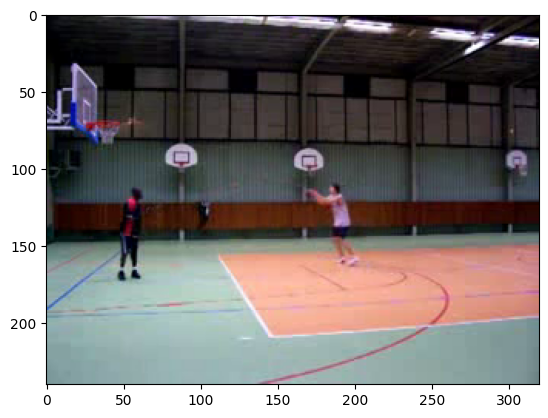

In [24]:
plt.imshow(video_thwc[-1].numpy().astype('uint8'))

`-` gif 만들기

In [25]:
frames = [frame.numpy().astype('uint8') for frame in video_thwc]
imageio.mimsave("sample.gif",frames)

In [26]:
IPython.display.Image("sample.gif")

`-` “텐서 $\to$ 영상” 이 되는 함수를 선언하자.

In [27]:
def _display_gif(video_cthw):
    video_thwc = video_cthw.permute(1,2,3,0)
    frames = [frame.numpy().astype('uint8') for frame in video_thwc]
    imageio.mimsave("sample.gif",frames)
    return IPython.display.Image("sample.gif")

In [28]:
_display_gif(next(_train_dataset)['video'])

`-` `pytorchvideo.data.make_clip_sampler("random", 10)` 의 의미: 영상을
보고 스스로 파악해보세요..

-   `pytorchvideo.data.make_clip_sampler("uniform", 10)` 의 의미도
    스스로 살펴보세요

In [29]:
_train_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("random", 1),
    decode_audio = False,
#    transform = train_transform,
)
_display_gif(next(_train_dataset)['video'])

## E. 모델생성

`-` imports

In [30]:
import transformers

`-` 모델생성

In [31]:
label2id = {
    'ApplyEyeMakeup': 0,
    'ApplyLipstick': 1,
    'Archery': 2,
    'BabyCrawling': 3,
    'BalanceBeam': 4,
    'BandMarching': 5,
    'BaseballPitch': 6,
    'Basketball': 7,
    'BasketballDunk': 8,
    'BenchPress': 9
}
id2label = {
    0: 'ApplyEyeMakeup',
    1: 'ApplyLipstick',
    2: 'Archery',
    3: 'BabyCrawling',
    4: 'BalanceBeam',
    5: 'BandMarching',
    6: 'BaseballPitch',
    7: 'Basketball',
    8: 'BasketballDunk',
    9: 'BenchPress'
}
model = transformers.VideoMAEForVideoClassification.from_pretrained(
    "MCG-NJU/videomae-base",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

## F. 변환 $\to$ tr/val/test 생성

`-` imports

In [32]:
import pytorchvideo.transforms
import torchvision.transforms

`-` 이미지전처리에 도움이 되는 `image_processor` 를 불러오는 코드

In [33]:
image_processor = transformers.VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base")

`-` 저장된값들

In [34]:
print(
    f"mean: {image_processor.image_mean}\n"
    f"std: {image_processor.image_std}\n"
    f"size: {image_processor.size}\n"
    f"resize_to: {(224,224)}\n"
    f"num_frames_to_sample: {model.config.num_frames}\n"
    f"clip_duration: {2.1333333333333333}"
)

mean: [0.485, 0.456, 0.406]
std: [0.229, 0.224, 0.225]
size: {'shortest_edge': 224}
resize_to: (224, 224)
num_frames_to_sample: 16
clip_duration: 2.1333333333333333

-   모델 `MCG-NJU/videomae-base` 의 성능을 최고로 이끌어 내기 위해서는
    어떠한 최적화된 변환이 있음
-   위에 제시된 값들은 그 최적화된 변환을 구현하기위해 필요한 값들임.

`-` 변환된 이미지텐서를 올바르게 출력하기 위해 `_display_gif` 를
수정하여 `display_gif` 를 만듦.

In [35]:
def display_gif(video_cthw):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    #---# 
    video_thwc = video_cthw.permute(1,2,3,0)
    frames = [] 
    for frame in video_thwc:
        img = frame = frame.numpy()
        img = (img * std) + mean 
        img = (img * 255).astype('uint8')
        img = img.clip(0,255)
        frames.append(img)
    imageio.mimsave("sample.gif",frames, duration=0.25)
    return IPython.display.Image("sample.gif")    

`-` 최적화된 변환을 적용하여 `train_dataset`을 불러옴

In [36]:
train_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("random", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
            key="video",
            transform=torchvision.transforms.Compose(
                [
                    pytorchvideo.transforms.UniformTemporalSubsample(16),
                    torchvision.transforms.Lambda(lambda x: x / 255.0),
                    pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                    pytorchvideo.transforms.RandomShortSideScale(min_size=256, max_size=320),
                    torchvision.transforms.RandomCrop((224,224)),
                    torchvision.transforms.RandomHorizontalFlip(p=0.5),
                ]
            ),
        )
)

`-` 이제 `val_dataset`, `test_dataset` 도 불러옴

In [37]:
val_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/val',
    clip_sampler = pytorchvideo.data.make_clip_sampler("uniform", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
            key="video",
            transform=torchvision.transforms.Compose(
                [
                    pytorchvideo.transforms.UniformTemporalSubsample(16),
                    torchvision.transforms.Lambda(lambda x: x / 255.0),
                    pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                    torchvision.transforms.Resize((224,224))
                ]
            ),
        )
)
test_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/test',
    clip_sampler = pytorchvideo.data.make_clip_sampler("uniform", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
            key="video",
            transform=torchvision.transforms.Compose(
                [
                    pytorchvideo.transforms.UniformTemporalSubsample(16),
                    torchvision.transforms.Lambda(lambda x: x / 255.0),
                    pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                    torchvision.transforms.Resize((224,224))
                ]
            ),
        )
)

## G. 데이터콜렉터

`-` 일단은 아래가 실행되지 않음을 관찰하자.

In [38]:
model(train_dataset) 

`-` 실행되는 형태1: `model(tsr_ntchw)`

In [18]:
examples = [next(train_dataset), next(train_dataset)]

**실행예시1**

In [19]:
model(examples[0]['video'].permute(1,0,2,3).reshape(1,16,3,224,224))

**실행예시2**

In [22]:
model(torch.stack([examples[0]['video'].permute(1,0,2,3), examples[1]['video'].permute(1,0,2,3)],axis=0))

**실행예시3**

In [23]:
model(torch.stack([example['video'].permute(1,0,2,3) for example in examples],axis=0))

`-` 실행되는 형태1:
`model(**{"pixel_values":tsr_ntchw, "labels":tsrlb_n})`

In [24]:
examples = [next(train_dataset), next(train_dataset)]
tsr_ntchw = torch.stack([example['video'].permute(1,0,2,3) for example in examples])
tsrlb_n = torch.tensor([example['label'] for example in examples])

In [25]:
model(**{"pixel_values":tsr_ntchw, "labels":tsrlb_n})

`-` 그렇다면 데이터콜렉터는?

In [40]:
def collate_fn(examples): # examples 는 [Dict, Dict, ...]
    tsr_ntchw = torch.stack([example['video'].permute(1,0,2,3) for example in examples])
    tsrlb_n = torch.tensor([example['label'] for example in examples])
    return dict(pixel_values=tsr_ntchw,labels=tsrlb_n)

In [42]:
# model(**collate_fn(val_dataset)) # 좀 오래걸리니까 실행하지 마세요

# 5. 코드정리

In [ ]:
import huggingface_hub
import tarfile 
import transformers
import pytorchvideo.data
import pytorchvideo.transforms
import torchvision.transforms
import evaluate
import torch
import numpy as np
# import imageio
# import IPython.display
# import matplotlib.pyplot as plt 
#---#
## Step1 
file_path = huggingface_hub.hf_hub_download(
    repo_id="sayakpaul/ucf101-subset", 
    filename="UCF101_subset.tar.gz", 
    repo_type="dataset"
)
with tarfile.open(file_path) as t:
    t.extractall(".")
train_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/train',
    clip_sampler = pytorchvideo.data.make_clip_sampler("random", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
            key="video",
            transform=torchvision.transforms.Compose(
                [
                    pytorchvideo.transforms.UniformTemporalSubsample(16),
                    torchvision.transforms.Lambda(lambda x: x / 255.0),
                    pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                    pytorchvideo.transforms.RandomShortSideScale(min_size=256, max_size=320),
                    torchvision.transforms.RandomCrop((224,224)),
                    torchvision.transforms.RandomHorizontalFlip(p=0.5),
                ]
            ),
        )
)
val_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/val',
    clip_sampler = pytorchvideo.data.make_clip_sampler("uniform", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
            key="video",
            transform=torchvision.transforms.Compose(
                [
                    pytorchvideo.transforms.UniformTemporalSubsample(16),
                    torchvision.transforms.Lambda(lambda x: x / 255.0),
                    pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                    torchvision.transforms.Resize((224,224))
                ]
            ),
        )
)
test_dataset = pytorchvideo.data.labeled_video_dataset(
    data_path = 'UCF101_subset/test',
    clip_sampler = pytorchvideo.data.make_clip_sampler("uniform", 2.1333333333333333),
    decode_audio = False,
    transform = pytorchvideo.transforms.ApplyTransformToKey(
            key="video",
            transform=torchvision.transforms.Compose(
                [
                    pytorchvideo.transforms.UniformTemporalSubsample(16),
                    torchvision.transforms.Lambda(lambda x: x / 255.0),
                    pytorchvideo.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                    torchvision.transforms.Resize((224,224))
                ]
            ),
        )
)
## Step2 
id2label = {
    0: 'ApplyEyeMakeup',
    1: 'Archery',
    2: 'BalanceBeam',
    3: 'BaseballPitch',
    4: 'BasketballDunk',
    5: 'ApplyLipstick',
    6: 'BabyCrawling',
    7: 'BandMarching',
    8: 'Basketball',
    9: 'BenchPress'
}
label2id = {
    'ApplyEyeMakeup': 0, 
    'Archery': 1,
    'BalanceBeam': 2,
    'BaseballPitch': 3,
    'BasketballDunk': 4,
    'ApplyLipstick': 5,
    'BabyCrawling': 6,
    'BandMarching': 7,
    'Basketball': 8,
    'BenchPress': 9 
}
model = transformers.VideoMAEForVideoClassification.from_pretrained(
    "MCG-NJU/videomae-base",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Step3 
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)
def collate_fn(examples): # examples 는 [Dict, Dict, ...]
    tsr_ntchw = torch.stack([example['video'].permute(1,0,2,3) for example in examples])
    tsrlb_n = torch.tensor([example['label'] for example in examples])
    return dict(pixel_values=tsr_ntchw,labels=tsrlb_n)
args = transformers.TrainingArguments(
    '동영상분류학습된모델',
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // 8) * 4,
    report_to="none"
)
image_processor = transformers.VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base")
trainer = transformers.Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
max_steps is given, it will override any value given in num_train_epochs

In [46]:
trainer.predict(test_dataset)

*추론하기*

In [57]:
video_cls = transformers.pipeline(
    task="video-classification",
    model="_영상분류학습된모델/checkpoint-72",
)
video_cls("UCF101_subset/test/BenchPress/v_BenchPress_g05_c02.avi")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.